In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats

In [85]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'
GC_content_tsv = f'../../../data/output/{file_names}/rolling_window/GC_content_rw/{promoter_pref}_GCcontent_rw.tsv'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'

In [8]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/GC_content_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/GC_content_rw/plots  created


In [81]:
promoters = pd.read_csv(Czechowski_gene_categories, sep='\t', header=None)
cols = ['AGI','gene_type']
promoters.columns = cols
GC_content = pd.read_table(GC_content_tsv, sep='\t', header=None)
GC_content
cols2 = ['name', 'percentage_GC_content']
GC_content.columns = cols2
#Make AGI column
GC_content['AGI'] = GC_content.name.str.split('_',expand=True)[0]
#make window number column
GC_content = GC_content.assign(window_number=GC_content.name.str.extract(r'_(.*?)\:'))
#make chr column
GC_content = GC_content.assign(chr=GC_content.name.str.split(':',n=3,expand=True)[2])
#make start column
GC_content = GC_content.assign(start=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[0])
#make stop column
GC_content = GC_content.assign(stop=GC_content.name.str.split(':',n=3,expand=True)[3].str.split('-',expand=True)[1])

#merge to limit to genes of interest
GC_content = pd.merge(promoters, GC_content)
GC_content

In [82]:
GC_content

,name,percentage_GC_content,AGI,window_number,chr,start,stop
0,AT1G01010_1::1:2630-2730,38.0,AT1G01010,1,1,2630,2730
1,AT1G01010_2::1:2680-2780,37.0,AT1G01010,2,1,2680,2780
2,AT1G01010_3::1:2730-2830,34.0,AT1G01010,3,1,2730,2830
3,AT1G01010_4::1:2780-2880,37.0,AT1G01010,4,1,2780,2880
4,AT1G01010_5::1:2830-2930,39.0,AT1G01010,5,1,2830,2930
...,...,...,...,...,...,...,...
363248,AT5G67640_5::5:26971368-26971468,40.0,AT5G67640,5,5,26971368,26971468
363249,AT5G67640_4::5:26971418-26971518,40.0,AT5G67640,4,5,26971418,26971518
363250,AT5G67640_3::5:26971468-26971568,40.0,AT5G67640,3,5,26971468,26971568
363251,AT5G67640_2::5:26971518-26971618,40.0,AT5G67640,2,5,26971518,26971618


In [83]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

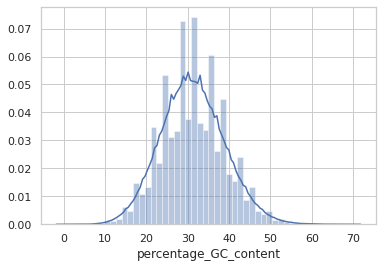

In [84]:
dist_plot = GC_content['percentage_GC_content']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

In [119]:
def windows_coords(promoter_bed,GC_content_df):
    """function to add the centre of each window corresponding to each window no."""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start
    #merge promoter_bed with GC_content_df on AGI
    merged = pd.merge(GC_content_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    #change column types
    merged = merged.astype({'start': 'int64','stop':'int64','chr':'int64','percentage_GC_content':'int64'})
    
    
    #calculate longest promoter length
    length_of_longest_promoter = merged.length.max()
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add coverage position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.start+0.5*(pos.stop-pos.start)) - pos.start_wholeprom
    neg['position'] = (neg.stop_wholeprom) - (neg.start+0.5*(neg.stop-neg.start))
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})

    #lineplot
    sns.lineplot(y=merged2.percentage_GC_content, x=merged2.position)
    plt.xlim(length_of_longest_promoter, 0)
    return merged2

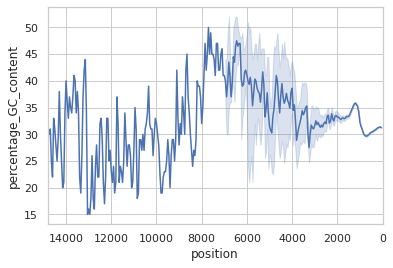

In [120]:
all_proms = windows_coords(promoter_bed, GC_content)

## Now do constitutive and variable promoter from Czechowski et al 2005

In [111]:
def add_genetype(df,gene_categories):
    """function to add gene type to the df, and remove random genes"""
    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, df, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [113]:
GC_prom_types = add_genetype(GC_content, Czechowski_gene_categories)

,AGI,gene_type,name,percentage_GC_content,window_number,chr,start,stop
0,AT1G01060,constitutive,AT1G01060_26::1:37093-37193,33.0,26,1,37093,37193
1,AT1G01060,constitutive,AT1G01060_25::1:37143-37243,32.0,25,1,37143,37243
2,AT1G01060,constitutive,AT1G01060_24::1:37193-37293,31.0,24,1,37193,37293
3,AT1G01060,constitutive,AT1G01060_23::1:37243-37343,38.0,23,1,37243,37343
4,AT1G01060,constitutive,AT1G01060_22::1:37293-37393,46.0,22,1,37293,37393
...,...,...,...,...,...,...,...,...
5301,AT2G40120,control,AT2G40120_5::2:16758299-16758399,34.0,5,2,16758299,16758399
5302,AT2G40120,control,AT2G40120_4::2:16758349-16758449,36.0,4,2,16758349,16758449
5303,AT2G40120,control,AT2G40120_3::2:16758399-16758499,28.0,3,2,16758399,16758499
5304,AT2G40120,control,AT2G40120_2::2:16758449-16758549,28.0,2,2,16758449,16758549


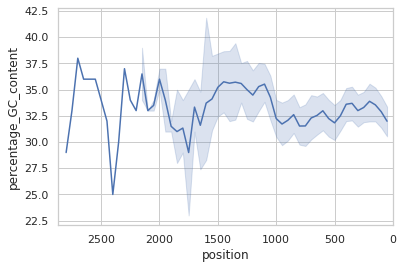

In [114]:
constitutive_rolling = windows_coords(promoter_bed,GC_prom_types[GC_prom_types.gene_type == 'constitutive'])

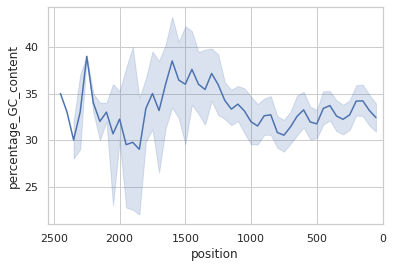

In [115]:
variable_rolling = windows_coords(promoter_bed,GC_prom_types[GC_prom_types.gene_type == 'variable'])

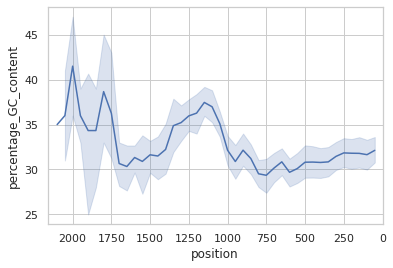

In [116]:
random_rolling = windows_coords(promoter_bed,GC_prom_types[GC_prom_types.gene_type == 'control'])

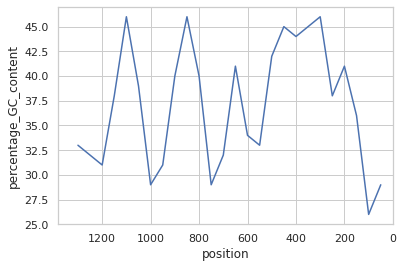

In [127]:
AT1G01060_rolling = windows_coords(promoter_bed,GC_prom_types[GC_prom_types.AGI == 'AT1G01060'])